---
title: "**pycaret** - a low-code machine learning library in Python (incl. **decision tree** and many other methods)"
---

# Objectives

- This demo code contains steps of a simplified version of the analysis in 
    - D'Amato, V., D'Ecclesia, R., and Levantesi, S. (2024). ***Firms' profitability and ESG score: A machine learning approach***.  https://doi.org/10.1002/asmb.2758 
    - Regression: 
        - $$EBITmargin \sim esg\_metric + lscope + Industry\_1d + PE + ROE + DY$$

- It uses the `pycaret` library to run **decision tree regression** required for the analysis

# Note: 

- When prompted to select a **kernel / Python Environment**, select the below from the list of kernels:

   `venv (Python 3.11.11) /opt/venv/bin/python`

- When prompted: ***Do you want to grant Kernel access to the extension Data Wrangler (ms-toolsai.datawrangler)?***
   - select `Allowed`

In [1]:
#!pip install pycaret       # installing pycaret library; need to install only once
#
# Note: If the above command does not work, try using the command (without the exclamation mark) in the terminal

from pycaret.regression import *

# Data files

- ESG_data_Provider_B.csv
    - The ESG_data.csv dataset after confining to `source == "Provider_B"`
    - ESG_data.csv is from Coqueret, G. (2024). Chapter 5: Green performance. In Sustainable finance: an introduction. https://www.greenfinance.education/green_perf.html

- ESGscore_Profitability.csv
    - Additional data downloaded from WRDS 
    - includes cash dividends, earnings per share available to common stockholders, etc  

# The **English** language as a programming language through the use of GitHub Copilot

**q**: Please suggest codes that read in ESG_data_Provider_B.csv and ESGscore_Profitability.csv, and merge ESG_data_Provider_B.csv into ESGscore_Profitability.csv by the combination of ESG_data_Provider_B.csv's "instrument" and "date" equal to  ESGscore_Profitability.csv's "tic" and "datadate"?

**a**: To read in ESG_data_Provider_B.csv and ESGscore_Profitability.csv, and merge ESG_data_Provider_B.csv into ESGscore_Profitability.csv by the combination of ESG_data_Provider_B.csv's "instrument" and "date" equal to ESGscore_Profitability.csv's "tic" and "datadate", you can use the following code in a Jupyter Notebook cell:

```python
import pandas as pd

# Read the CSV files
esg_data = pd.read_csv('ESG_data_Provider_B.csv')
profitability_data = pd.read_csv('ESGscore_Profitability.csv')

# Merge the dataframes
merged_data = pd.merge(profitability_data, esg_data, left_on=['tic', 'datadate'], right_on=['instrument', 'date'], how='left')

# Display the merged dataframe
print(merged_data)
```

This code will read the two CSV files into pandas DataFrames and merge them based on the specified columns. The how='left' parameter ensures that the merged data will have the same number of rows as ESGscore_Profitability.csv.



In [2]:
import pandas as pd

# Read the CSV files
esg_data = pd.read_csv('ESG_data_Provider_B.csv')
profitability_data = pd.read_csv('ESGscore_Profitability.csv')

# Merge the dataframes
merged_data = pd.merge(profitability_data, esg_data, left_on=['tic', 'datadate'], right_on=['instrument', 'date'], how='left')

# Sort merged_data by GVKEY (descending) and datadate (ascending)
merged_data = merged_data.sort_values(by=['GVKEY', 'datadate'], ascending=[False, True])
# Display the merged dataframe
print(merged_data)

        GVKEY LINKPRIM  LIID LINKTYPE  LPERMNO  LPERMCO      LINKDT  \
11588  316056        P     1       LC    14297    54641  2013-12-02   
11589  316056        P     1       LC    14297    54641  2013-12-02   
11590  316056        P     1       LC    14297    54641  2013-12-02   
11591  316056        P     1       LC    14297    54641  2013-12-02   
11592  316056        P     1       LC    14297    54641  2013-12-02   
...       ...      ...   ...      ...      ...      ...         ...   
11       1045        P     1       LC    21020    20010  1962-01-31   
12       1045        P     1       LC    21020    20010  1962-01-31   
13       1045        P     1       LC    21020    20010  1962-01-31   
14       1045        P     1       LC    21020    20010  1962-01-31   
15       1045        P     1       LC    21020    20010  1962-01-31   

        LINKENDDT    datadate  fyear  ... instrument          name  \
11588           E  2013-12-31   2013  ...       ALLE  Allegion PLC   
11589  

# Handling missing values of **cdvc** (Cash dividends on common stock)

**q**: How to replace missing values of cdvc by zero?

**a**: You can replace missing values in the `cdvc` column with zero using the `fillna` method. Here is how you can modify the code to achieve this:

```python
# Replace missing values in 'cdvc' column with zero
merged_data['cdvc'] = merged_data['cdvc'].fillna(0)
```

In [3]:

# cdvc: Cash dividends on common stock

# (Note: 'cdvc' will not appear in cash flow statement if there is no dividend in that year.)

# Replace missing values in 'cdvc' column with zero
merged_data['cdvc'] = merged_data['cdvc'].fillna(0)


# Constructing new variables for running regression later

- $$EBITmargin \sim esg\_metric + lscope + Industry\_1d + PE + ROE + DY$$

---

**q**: How to construct the following new variable in the merge_data dataframe?

EBITmargin = ebit/ sale

**a**: To construct the new variable `EBITmargin` in the `merged_data` dataframe, you can use the following code:

```python
# Assuming merge_data is already defined and contains the columns 'ebit' and 'sale'
merged_data['EBITmargin'] = merged_data['ebit'] / merged_data['sale']
```

This code will create a new column `EBITmargin` in the `merged_data` dataframe by dividing the values in the `ebit` column by the values in the `sale` column.





In [4]:
import numpy as np 

# Assuming merge_data is already defined and contains the columns 'ebit' and 'sale'
merged_data['EBITmargin'] = merged_data['ebit'] / merged_data['sale']

# Construct more variables
# Price-to-Earnings ratio:
merged_data['PE'] = merged_data['prcc_f'] / merged_data['epspx']   
    # prcc_f: closing price on fiscal year end
    # epspx: Basic earnings per share excluding extraordinary items
# Return on Equity:
merged_data['ROE'] = merged_data['ibcom'] / merged_data['ceq']  
    # ibcom: Income before extraordinary items and discontinued operations available to common stockholders
    # ceq: Common equity
# Total carbon emissions:
merged_data['lscope'] = np.log1p(merged_data['scope_1'] + merged_data['scope_2'] + merged_data['scope_3'])
    # np.log1p() is the natural logarithm of 1 plus the input array, which is useful for transforming data that may contain zero values, as it avoids taking the logarithm of zero, which is undefined.

#=======================================================================================================
# Note: D'Amato et al (2024) define DY as the ratio of cash dividends on common stock to the closing price on fiscal year end of the **previous year**. So the following definition of DY is incorrect. 
#=======================================================================================================
# Dividend Yield:
#merged_data['DY'] = merged_data['cdvc'] / merged_data['prcc_f']  
    # cdvc: Cash dividends on common stock

# Grouping data by GVKEY before defining DY using lag value of prcc_f after sorting


**q**: How to modify the below to define DY based on the lag value of prcc_f after grouping merged_data by GVKEY and sorting prcc_f in ascending order?

```python
merged_data['DY'] = merged_data['cdvc'] / merged_data['prcc_f']
```


**a**: To define `DY` based on the lag value of `prcc_f` after grouping merged_data by `GVKEY` and sorting `prcc_f` in ascending order, you can use the `groupby` and `shift` methods in pandas. Here is how you can modify the code:

```python
# Assuming merged_data is already defined and contains the columns 'cdvc', 'prcc_f', and 'GVKEY'

# Define DY based on the lag value of prcc_f after grouping by GVKEY and sorting prcc_f in ascending order
merged_data = merged_data.sort_values(by=['GVKEY', 'prcc_f'])
merged_data['prcc_f_lag'] = merged_data.groupby('GVKEY')['prcc_f'].shift(1)
merged_data['DY'] = merged_data['cdvc'] / merged_data['prcc_f_lag']

# Drop the temporary 'prcc_f_lag' column if not needed
merged_data = merged_data.drop(columns=['prcc_f_lag'])

# Now you can use merged_data with the new DY column
print(merged_data.head())
```

In this code:

1. The DataFrame `merged_data` is sorted by `GVKEY` and `prcc_f` in ascending order.
2. The `shift` method is used to create a new column `prcc_f_lag` that contains the lagged values of `prcc_f` within each `GVKEY` group.
3. The DY column is calculated using `cdvc` divided by `prcc_f_lag`.
4. The temporary `prcc_f_lag` column is dropped if it is not needed.


In [5]:

# Define DY based on the lag value of prcc_f after grouping by GVKEY and sorting prcc_f in ascending order
merged_data = merged_data.sort_values(by=['GVKEY', 'prcc_f'])
merged_data['prcc_f_lag'] = merged_data.groupby('GVKEY')['prcc_f'].shift(1)
merged_data['DY'] = merged_data['cdvc'] / merged_data['prcc_f_lag']

# Drop the temporary 'prcc_f_lag' column if not needed
merged_data = merged_data.drop(columns=['prcc_f_lag'])

# Sort merged_data by GVKEY (descending) and datadate (ascending)
merged_data = merged_data.sort_values(by=['GVKEY', 'datadate'], ascending=[False, True])
# Now you can use merged_data with the new DY column
q: print(merged_data.head())

        GVKEY LINKPRIM  LIID LINKTYPE  LPERMNO  LPERMCO      LINKDT LINKENDDT  \
11588  316056        P     1       LC    14297    54641  2013-12-02         E   
11589  316056        P     1       LC    14297    54641  2013-12-02         E   
11590  316056        P     1       LC    14297    54641  2013-12-02         E   
11591  316056        P     1       LC    14297    54641  2013-12-02         E   
11592  316056        P     1       LC    14297    54641  2013-12-02         E   

         datadate  fyear  ... profit_margin esg_metric scope_1 scope_2  \
11588  2013-12-31   2013  ...      41.77619  40.613278     NaN     NaN   
11589  2014-12-31   2014  ...      40.36728  28.569383     NaN     NaN   
11590  2015-12-31   2015  ...      42.68169  32.065596     NaN     NaN   
11591  2016-12-31   2016  ...      44.22252  34.501785  18.257  59.447   
11592  2017-12-31   2017  ...      44.55195  47.908995     NaN     NaN   

      scope_3 EBITmargin          PE        ROE  lscope   DY  
11588

# Define the industry sector Industry_1d based on the first digit of the four-dight sich (historical SIC code)

- For example, if sic = 4321, 
    - (sich / 1000) = 4.321
    - int(4.321) = 4


In [6]:
# Convert 'sich' to integer type, handling NaN values
merged_data['sich'] = merged_data['sich'].astype('Int64')

# Extracting the first one digit of 'sich', leaving missing values as is
merged_data['Industry_1d'] = merged_data['sich'].apply(lambda x: int(x / 1000) if pd.notnull(x) else x)

# Define year variable
#merged_data['year'] = merged_data['datadate'].str[:4].astype('Int64')

print(merged_data.head())

        GVKEY LINKPRIM  LIID LINKTYPE  LPERMNO  LPERMCO      LINKDT LINKENDDT  \
11588  316056        P     1       LC    14297    54641  2013-12-02         E   
11589  316056        P     1       LC    14297    54641  2013-12-02         E   
11590  316056        P     1       LC    14297    54641  2013-12-02         E   
11591  316056        P     1       LC    14297    54641  2013-12-02         E   
11592  316056        P     1       LC    14297    54641  2013-12-02         E   

         datadate  fyear  ... esg_metric scope_1 scope_2 scope_3 EBITmargin  \
11588  2013-12-31   2013  ...  40.613278     NaN     NaN     NaN   0.173585   
11589  2014-12-31   2014  ...  28.569383     NaN     NaN     NaN   0.186612   
11590  2015-12-31   2015  ...  32.065596     NaN     NaN     NaN   0.191383   
11591  2016-12-31   2016  ...  34.501785  18.257  59.447     NaN   0.191510   
11592  2017-12-31   2017  ...  47.908995     NaN     NaN     NaN   0.209783   

               PE        ROE lscope   

# More data preparation

- select relevant columns 
- filter missing-value observations
- create industry dummy variables from categorical variable Industry_1d
- review the data prepared

In [7]:
# Select relevant columns
data = merged_data[['GVKEY', 'datadate', 
                    'EBITmargin', 'esg_metric', 'lscope',
                    'Industry_1d', #'year', 
                    'PE', 'ROE', 'DY', 
                    'sich'
                    ]]

# Drop rows with missing values
data = data.dropna()

# Convert categorical variables to dummy variables if necessary
data = pd.get_dummies(data, columns=['Industry_1d'], drop_first=True)
#data = pd.get_dummies(data, columns=['year'], drop_first=True)

# Sort merged_data by sich (ascending), GVKEY (descending), and datadate (ascending)
data = data.sort_values(by=['sich', 'GVKEY', 'datadate'], ascending=[True, False, True])

#=================================================================
# Display the dataFrame for review
from IPython.display import display
display(data)


,GVKEY,datadate,EBITmargin,esg_metric,lscope,PE,ROE,DY,sich,Industry_1d_1,Industry_1d_2,Industry_1d_3,Industry_1d_4,Industry_1d_5,Industry_1d_6,Industry_1d_7,Industry_1d_8,Industry_1d_9
8795,35168,2020-12-31,0.059295,56.210266,8.871084,39.510204,0.029649,0.0,100,False,False,False,False,False,False,False,False,False
8796,35168,2021-12-31,0.084126,54.412934,8.903272,19.219512,0.071384,0.0,100,False,False,False,False,False,False,False,False,False
8797,35168,2022-12-31,0.112346,63.758409,9.137777,35.197605,0.047625,0.0,100,False,False,False,False,False,False,False,False,False
8798,35168,2023-12-31,0.125678,63.758409,9.137777,36.580153,0.037105,0.0,100,False,False,False,False,False,False,False,False,False
3989,7881,2010-12-31,0.437002,81.684326,8.544788,13.098081,0.172724,0.0,1040,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2418,5047,2020-12-31,0.042176,76.885918,7.852050,18.305085,0.150650,0.0,9997,False,False,False,False,False,False,False,False,True
151,1300,2020-12-31,0.192144,75.032489,9.853279,31.325479,0.272323,0.0,9997,False,False,False,False,False,False,False,False,True
152,1300,2021-12-31,0.196819,82.076369,9.845415,26.031211,0.298454,0.0,9997,False,False,False,False,False,False,False,False,True
153,1300,2022-12-31,0.206057,80.677111,9.901410,29.236016,0.297419,0.0,9997,False,False,False,False,False,False,False,False,True


# Final steps of data preparation

- Retain only the columns for Classification and Regression Training (Caret)
- Convert Inf and -Inf to NaN and remove all NaN's
    - Otherwise, the decision tree method of pycaret will complain

In [10]:
import numpy as np

# Retain only the columns for Classification and Regression Training (Caret)
#  by removing 'GVKEY', 'datadate', 'sich' columns
data_caret = data.drop(columns=['GVKEY', 'datadate', 'sich'])

# Replace Inf and -Inf with NaN
data_caret = data_caret.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values (which includes NaN converted from Inf and -Inf)
data_caret = data_caret.dropna()

# Report the summary statistics of data_caret
summary_statistics = data_caret.describe()
print(summary_statistics)

        EBITmargin   esg_metric       lscope           PE          ROE  \
count  3113.000000  3113.000000  3113.000000  3113.000000  3113.000000   
mean      0.198282    67.891090     7.583859    26.595078     0.256979   
std       0.164258    13.297966     2.354437   189.207642     4.592278   
min      -3.938894     5.873696     1.272698 -2873.000000   -65.363636   
25%       0.115228    60.379434     5.713640    13.343248     0.082750   
50%       0.175631    69.676839     7.362820    19.364994     0.150251   
75%       0.267604    77.358239     9.525763    28.913636     0.267451   
max       0.675879    95.162371    13.973117  7697.000000   216.095238   

                DY  
count  3113.000000  
mean      1.370684  
std       5.967798  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max      77.509728  


# Initialize PyCaret environment

In [11]:

reg_setup = setup(data_caret, target='EBITmargin', session_id=123, normalize=True, transformation=True, train_size=0.8)

,Description,Value
0,Session id,123
1,Target,EBITmargin
2,Target type,Regression
3,Original data shape,"(3113, 15)"
4,Transformed data shape,"(3113, 15)"
5,Transformed train set shape,"(2490, 15)"
6,Transformed test set shape,"(623, 15)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


# Compare linear regression to **untuned** decision tree regression 

In [12]:

# Create and train the models
lr_model = create_model('lr')
dt_model = create_model('dt')

# Compare the untuned models
models_to_compare = [lr_model, dt_model]
best_model = compare_models(include=models_to_compare)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1026,0.0258,0.1608,0.0905,0.1093,2.2402
1,0.1054,0.0187,0.1367,0.0761,0.0998,0.9634
2,0.0997,0.0185,0.1361,0.2203,0.0978,0.8927
3,0.0897,0.0137,0.1170,0.1330,0.0924,0.9046
4,0.1093,0.0884,0.2973,0.0530,0.1355,0.8065
5,0.0978,0.0230,0.1516,0.1374,0.0998,0.8162
6,0.0946,0.0171,0.1306,0.1349,0.0987,1.0681
7,0.0874,0.0130,0.1140,0.1593,0.0906,0.8323
8,0.0903,0.0141,0.1188,0.1475,0.0919,0.8049


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0923,0.0401,0.2001,-0.4093,0.1022,0.9532
1,0.0957,0.0263,0.1622,-0.3012,0.1169,0.6837
2,0.0873,0.0185,0.1360,0.2213,0.1044,0.5769
3,0.0860,0.0169,0.1301,-0.0716,0.1000,0.5382
4,0.0980,0.0415,0.2037,0.5552,0.1109,0.7170
5,0.1016,0.0289,0.1699,-0.0841,0.1201,1.6873
6,0.0865,0.0183,0.1352,0.0737,0.1015,0.7956
7,0.0857,0.0162,0.1273,-0.0487,0.1021,0.9106
8,0.0768,0.0142,0.1190,0.1447,0.0901,0.5710


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Linear Regression,0.0971,0.0248,0.1488,0.1390,0.1011,1.0335,0.0700
1,Decision Tree Regressor,0.0889,0.0234,0.1500,0.0416,0.1038,0.8101,0.0710


# Compare linear regression to **tuned** decision tree regression 

In [13]:
# Tune the models
tuned_dt = tune_model(dt_model)

# Compare the tuned models
models_to_compare = [lr_model, tuned_dt]
best_model = compare_models(include=models_to_compare)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0839,0.0130,0.1142,0.5412,0.0878,1.9682
1,0.0858,0.0139,0.1180,0.3114,0.0908,0.6962
2,0.0928,0.0176,0.1328,0.2578,0.0976,0.7455
3,0.0826,0.0134,0.1157,0.1525,0.0898,0.7724
4,0.1014,0.0814,0.2853,0.1275,0.1422,0.6510
5,0.0914,0.0204,0.1427,0.2356,0.1001,0.6681
6,0.0865,0.0146,0.1207,0.2611,0.0960,1.0284
7,0.0732,0.0099,0.0993,0.3622,0.0795,0.6990
8,0.0830,0.0125,0.1116,0.2466,0.0821,0.6878


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
1,Decision Tree Regressor,0.0867,0.0211,0.1360,0.2798,0.0961,0.8854,0.0570
0,Linear Regression,0.0971,0.0248,0.1488,0.1390,0.1011,1.0335,0.0620


# Display Feature Importance plot and Decision Tree plot of the decision tree model

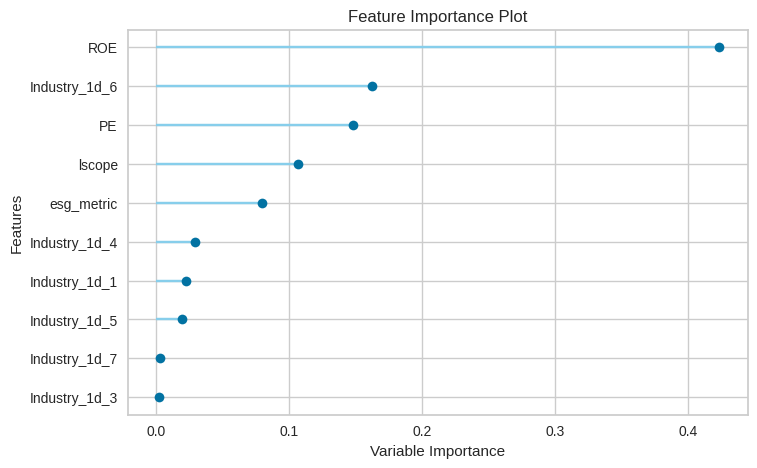

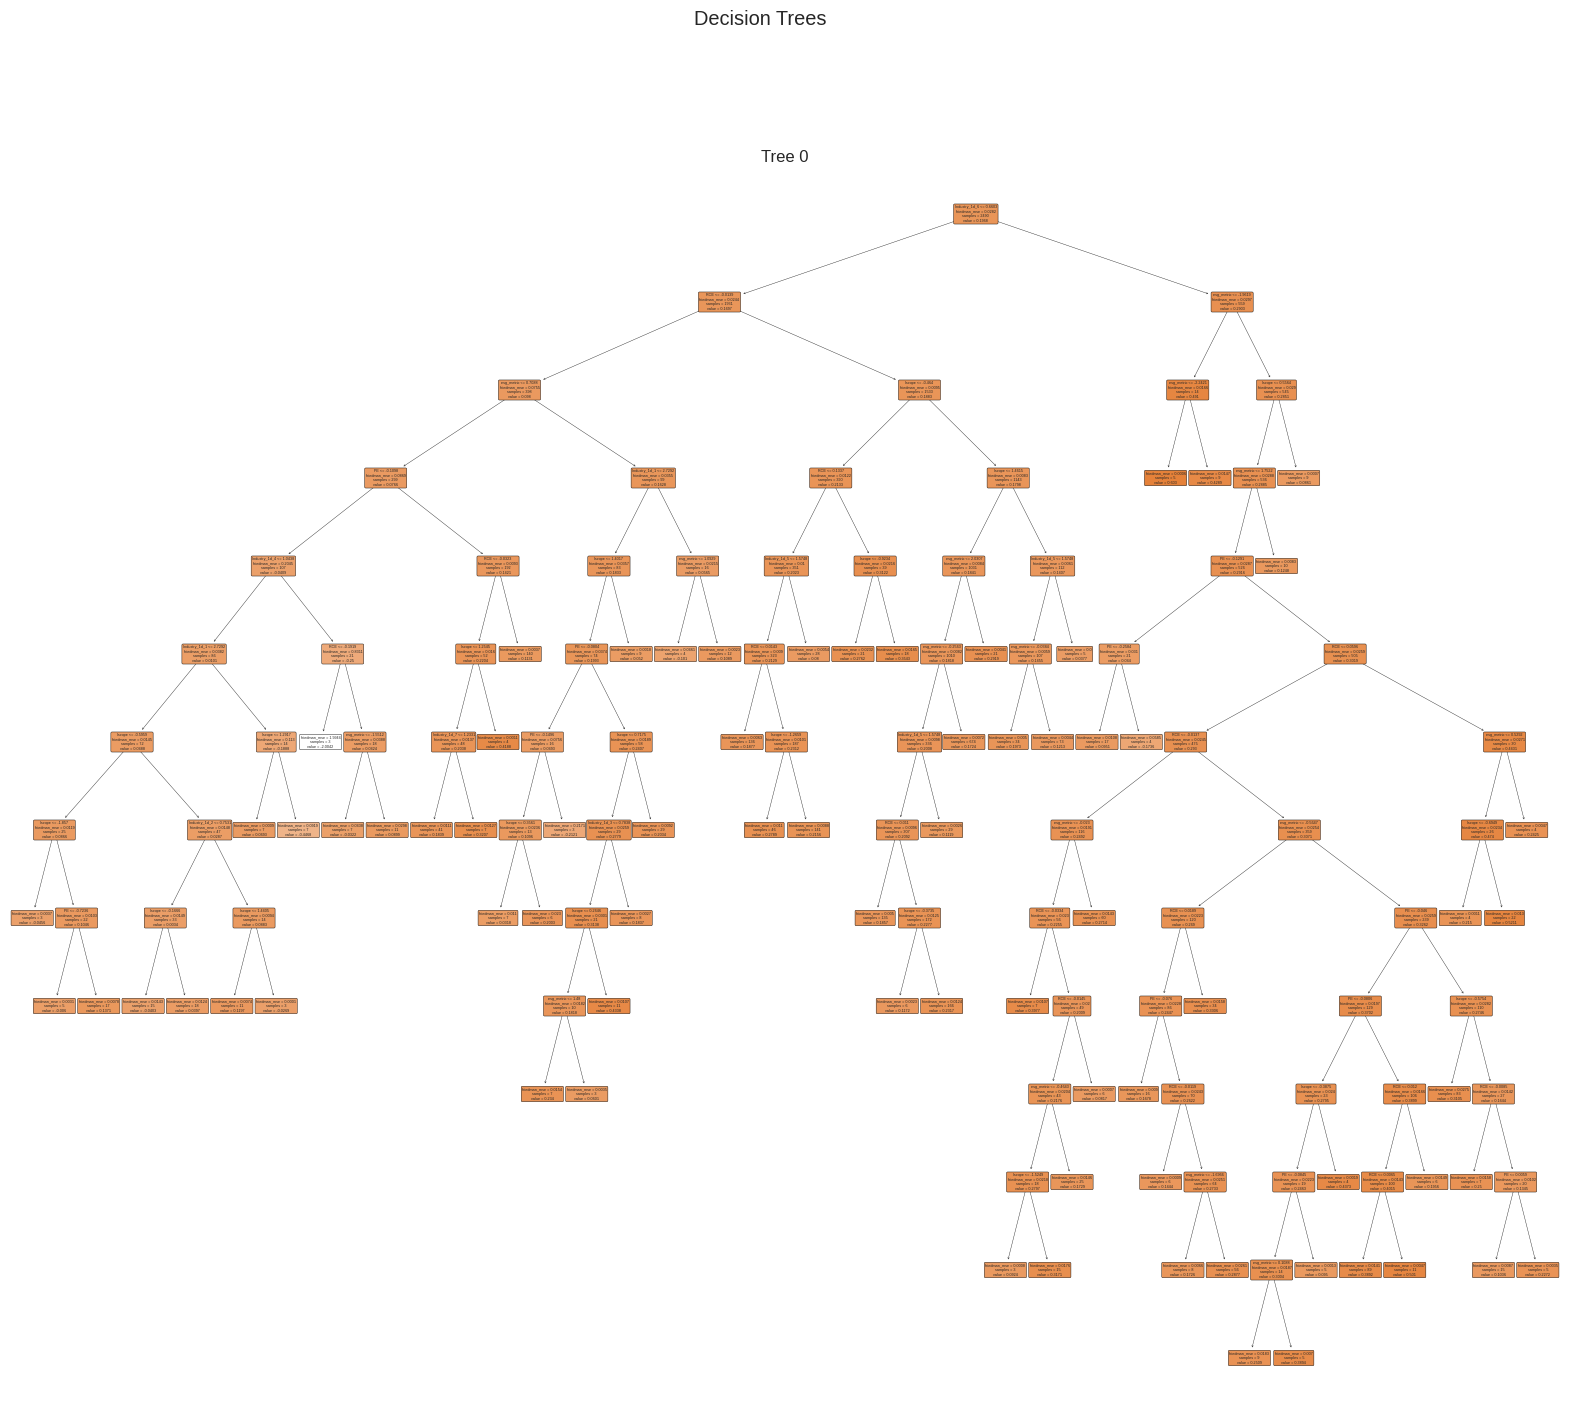

In [14]:
# Evaluate Decision Tree model - Feature Importance plot
plot_model(tuned_dt, plot='feature')

# Evaluate Decision Tree model - Decision Tree plot
plot_model(tuned_dt, plot='tree')

# Note: require **reloading the window** after the installation below for it to become effective

**q**: How to reload the window?

**a**: Use the **Developer: Reload Window** command to reload the Visual Studio Code window.

 `Ctrl + Shift + P` to `Show in Command Palette` 

In [15]:
# Install library for analyzing the models
!pip install pycaret[analysis]     # need to install only once 


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Display SHAP (SHapley Additive exPlanations) summary plot (aka. Beeswarm plot) of the decision tree model

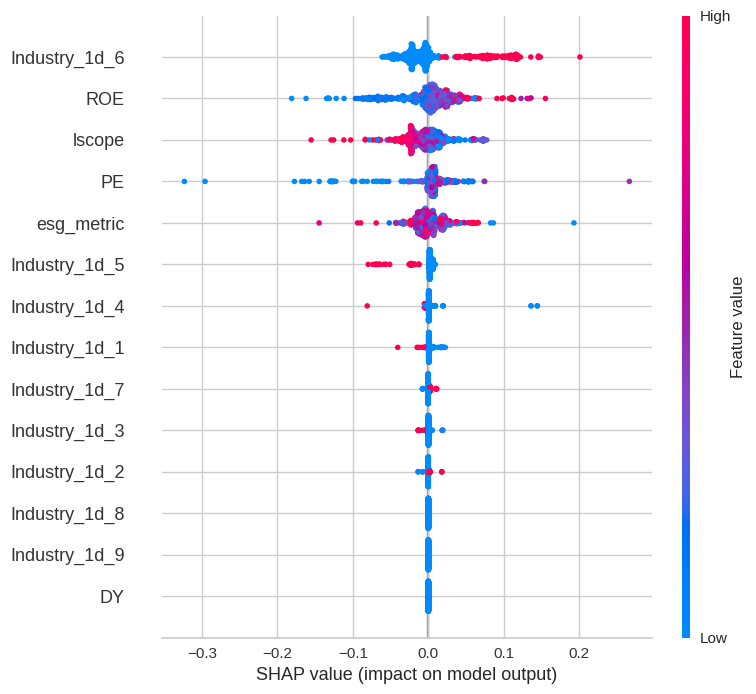

In [16]:
# Interpret Decision Tree model
# Note: For decision tree models, this will display the SHAP (SHapley Additive exPlanations) summary plot (aka. Beeswarm plot)
interpret_model(tuned_dt)

# Display the estimated coefficients of the PyCaret linear regression model

- Note: PyCaret does not provide statistical details like standard errors, p-value, etc out of the box 

In [16]:

from pycaret.regression import get_config  # Or use pycaret.regression if working with regression models

# Get the training dataset
X_train = get_config('X_train')  # Features of the training set
y_train = get_config('y_train')  # Target variable of the training set

# Display coefficients and intercept from PyCaret's linear regression model
coefficients = pd.DataFrame({
    'Feature': ['Intercept'] + list(X_train.columns),
    'Coefficient': [lr_model.intercept_] + list(lr_model.coef_)
})

# Display the coefficients table
print(coefficients)

          Feature  Coefficient
0       Intercept     0.196789
1      esg_metric    -0.000849
2          lscope    -0.016533
3              PE     0.005861
4             ROE     0.000491
5              DY     0.018804
6   Industry_1d_1    -0.000122
7   Industry_1d_2     0.040887
8   Industry_1d_3     0.022524
9   Industry_1d_4     0.012315
10  Industry_1d_5     0.001538
11  Industry_1d_6     0.071517
12  Industry_1d_7     0.027884
13  Industry_1d_8     0.008188
14  Industry_1d_9     0.002911
